In [19]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.metrics import (
    precision_score, recall_score, confusion_matrix, roc_auc_score,
    RocCurveDisplay, accuracy_score, f1_score, classification_report,
    balanced_accuracy_score, fbeta_score, precision_recall_curve, roc_curve)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from scipy.stats import skew
import xgboost as xgb
from sklearn.metrics import fbeta_score, make_scorer

# Preprocessing

In [47]:
import pandas as pd
import tkinter as tk
from tkinter import filedialog
import os

# Create a hidden root window
root = tk.Tk()
root.withdraw()

# Open the file selection dialog
file_path = filedialog.askopenfilename(
    title="Choose CSV files",
    filetypes=[("CSV files", "*.csv"), ("All files", "*.*")]
)

if file_path:
    data = pd.read_csv(file_path).drop('Checkup', axis=1)
    print("Data loading successful！")
    print(data.head(5))
else:
    print("No file selected")

Data loading successful！
  General_Health Exercise Heart_Disease Skin_Cancer Other_Cancer Depression  \
0           Poor       No            No          No           No         No   
1      Very Good       No           Yes          No           No         No   
2      Very Good      Yes            No          No           No         No   
3           Poor      Yes           Yes          No           No         No   
4           Good       No            No          No           No         No   

  Diabetes Arthritis     Sex Age_Category  Height_(cm)  Weight_(kg)    BMI  \
0       No       Yes  Female        70-74        150.0        32.66  14.54   
1      Yes        No  Female        70-74        165.0        77.11  28.29   
2      Yes        No  Female        60-64        163.0        88.45  33.47   
3      Yes        No    Male        75-79        180.0        93.44  28.73   
4       No        No    Male          80+        191.0        88.45  24.37   

  Smoking_History  Alcohol_Cons

In [3]:
# create participant ID
data.insert(0, 'ID', data.index)

In [4]:
# look for missing values
missing_values = data.isnull().sum()
missing_values

ID                              0
General_Health                  0
Exercise                        0
Heart_Disease                   0
Skin_Cancer                     0
Other_Cancer                    0
Depression                      0
Diabetes                        0
Arthritis                       0
Sex                             0
Age_Category                    0
Height_(cm)                     0
Weight_(kg)                     0
BMI                             0
Smoking_History                 0
Alcohol_Consumption             0
Fruit_Consumption               0
Green_Vegetables_Consumption    0
FriedPotato_Consumption         0
dtype: int64

In [5]:
# data type inspection
print(data.dtypes)

ID                                int64
General_Health                   object
Exercise                         object
Heart_Disease                    object
Skin_Cancer                      object
Other_Cancer                     object
Depression                       object
Diabetes                         object
Arthritis                        object
Sex                              object
Age_Category                     object
Height_(cm)                     float64
Weight_(kg)                     float64
BMI                             float64
Smoking_History                  object
Alcohol_Consumption             float64
Fruit_Consumption               float64
Green_Vegetables_Consumption    float64
FriedPotato_Consumption         float64
dtype: object


In [6]:
# convert categorical variables to category
categorical_cols = ['General_Health', 'Age_Category', 'Sex']
for col in categorical_cols:
  data[col] = data[col].astype('category')



# convert binary cols (yes/no) to binary (1/0)
binary_cols = ['Exercise', 'Heart_Disease', 'Skin_Cancer', 'Other_Cancer',
               'Depression', 'Diabetes', 'Arthritis', 'Smoking_History']
for col in binary_cols:
  # if string contains 'Yes' or 'No' due to pre-diabetes and gestational diabetes:
  data[col] = data[col].apply(lambda x: 1 if 'Yes' in str(x) else (0 if 'No' in str(x) else x))
  data[col] = data[col].astype('category')


data.head(10)



,ID,General_Health,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,0,Poor,0,0,0,0,0,0,1,Female,70-74,150.0,32.66,14.54,1,0.0,30.0,16.0,12.0
1,1,Very Good,0,1,0,0,0,1,0,Female,70-74,165.0,77.11,28.29,0,0.0,30.0,0.0,4.0
2,2,Very Good,1,0,0,0,0,1,0,Female,60-64,163.0,88.45,33.47,0,4.0,12.0,3.0,16.0
3,3,Poor,1,1,0,0,0,1,0,Male,75-79,180.0,93.44,28.73,0,0.0,30.0,30.0,8.0
4,4,Good,0,0,0,0,0,0,0,Male,80+,191.0,88.45,24.37,1,0.0,8.0,4.0,0.0
5,5,Good,0,0,0,0,1,0,1,Male,60-64,183.0,154.22,46.11,0,0.0,12.0,12.0,12.0
6,6,Fair,1,1,0,0,0,0,1,Male,60-64,175.0,69.85,22.74,1,0.0,16.0,8.0,0.0
7,7,Good,1,0,0,0,0,0,1,Female,65-69,165.0,108.86,39.94,1,3.0,30.0,8.0,8.0
8,8,Fair,0,0,0,0,1,0,0,Female,65-69,163.0,72.57,27.46,1,0.0,12.0,12.0,4.0
9,9,Fair,0,0,0,0,0,1,1,Female,70-74,163.0,91.63,34.67,0,0.0,12.0,12.0,1.0


In [7]:
numeric_cols = ['Height_(cm)', 'Weight_(kg)', 'BMI', 'Alcohol_Consumption',
                'Green_Vegetables_Consumption', 'FriedPotato_Consumption']

# scaling the numeric data for models, mean: 0, sd: 1
scaler = StandardScaler()
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])


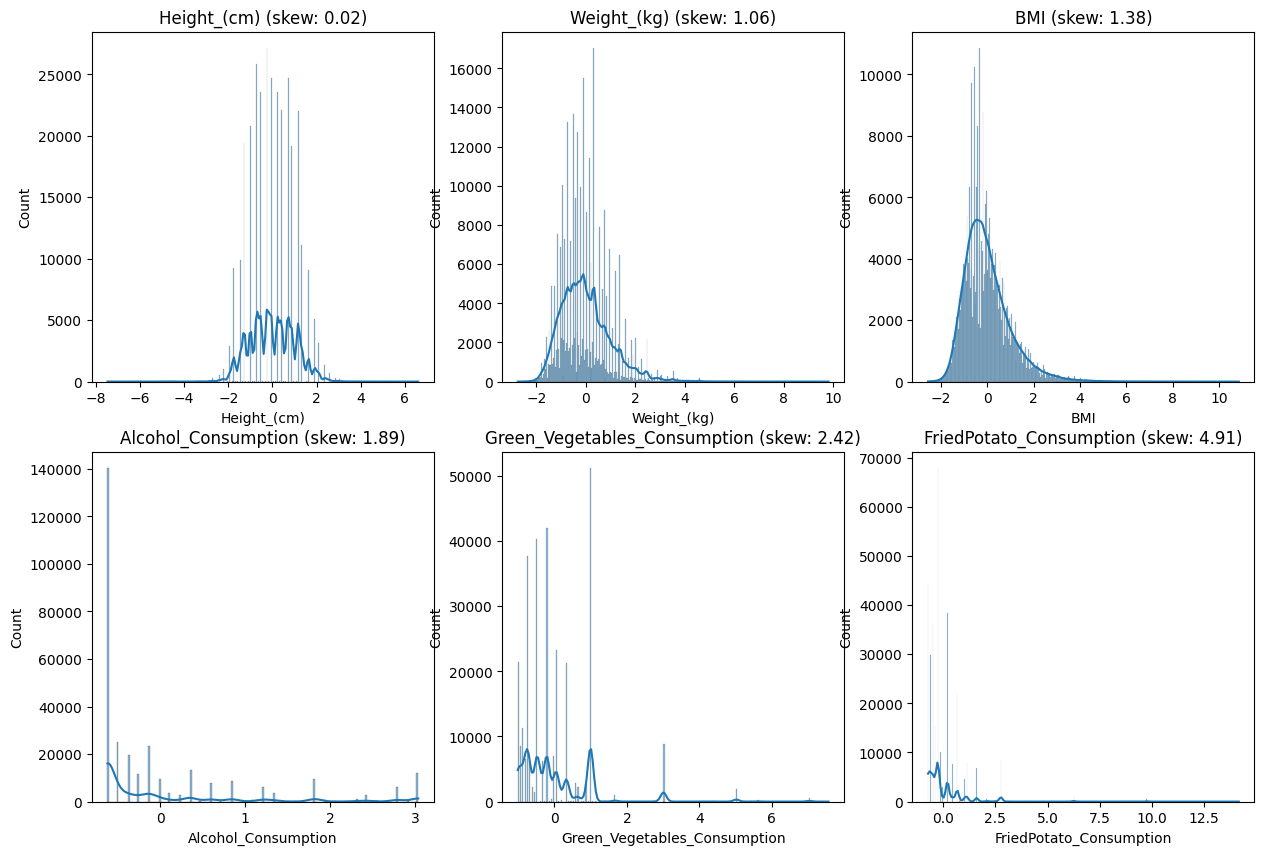

In [8]:
# analysing skewed features to assess if normalisation is required
fig, axes = plt.subplots(2, 3, figsize = (15, 10))
axes = axes.ravel()
skewness = data[numeric_cols].skew()

for i, col in enumerate(numeric_cols):
    sns.histplot(data[col], ax = axes[i], kde = True)
    axes[i].set_title(f'{col} (skew: {round(skewness[col],2)})')

plt.show()

In [9]:
# normalising all numeric features with skew > 1
skewed_cols = [col for col in numeric_cols if data[col].skew() > 1]

# using yeojohnson to deal with 0 values
yeojohnson_transformer = PowerTransformer(method = 'yeo-johnson')
data[skewed_cols] = yeojohnson_transformer.fit_transform(data[skewed_cols])

In [10]:
# train test split (can do this last since our preprocessing does not touch Heart_Disease other than binary conversion)
X = data.drop('Heart_Disease', axis=1)
y = data['Heart_Disease']

# 80-20 split due to class imbalance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2,
    random_state=1, stratify=y)

print('training:', X_train.shape[0], 'individuals')
print('test:', X_test.shape[0], 'individuals\n')
print('case/control distribution in training set:', y_train.value_counts(normalize=True), '\n')
print('case/control distribution in test set:', y_test.value_counts(normalize=True))

training: 247083 individuals
test: 61771 individuals

case/control distribution in training set: Heart_Disease
0    0.919149
1    0.080851
Name: proportion, dtype: float64 

case/control distribution in test set: Heart_Disease
0    0.919153
1    0.080847
Name: proportion, dtype: float64


In [11]:
# save preprocessed data
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')
y_train.to_pickle('y_train.pkl')
y_test.to_pickle('y_test.pkl')

<br>

# ML Models

In [12]:
# load data
X_train = pd.read_pickle('X_train.pkl')
X_test = pd.read_pickle('X_test.pkl')
y_train = pd.read_pickle('y_train.pkl')
y_test = pd.read_pickle('y_test.pkl')


n_iterations = 100     # for hyperparmeter tuning
cv_folds = 5           # number of cross validation folds for hyperparameter tuning

### XGBoost (Ziheng)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best hyperparameters: {'subsample': 0.9, 'scale_pos_weight': 12, 'n_estimators': 700, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.9}
Best cross-validation AUC score: 0.3101
Accuracy: 0.6810
Recall: 0.8512
Precision: 0.1832
F1-Score: 0.3014
AUC-ROC: 0.8337


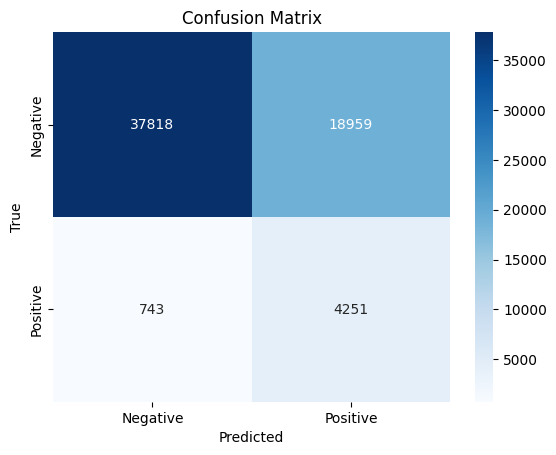

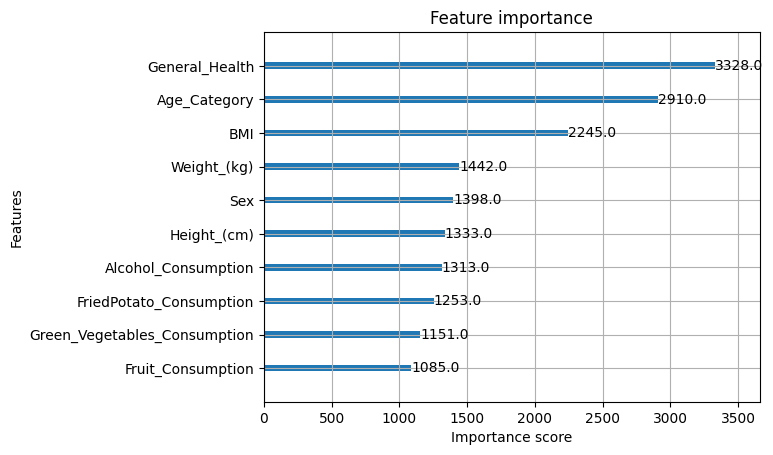


Classification Report:
              precision    recall  f1-score   support

      No CVD     0.9807    0.6661    0.7933     56777
         CVD     0.1832    0.8512    0.3014      4994

    accuracy                         0.6810     61771
   macro avg     0.5819    0.7587    0.5474     61771
weighted avg     0.9163    0.6810    0.7536     61771



In [40]:

X_train = X_train.drop(columns=['ID'], axis=1)
X_test = X_test.drop(columns=['ID'], axis=1)

cv_folds = 5

# Preprocessing: Label encode categorical features
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Label encoding for categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    le.fit(pd.concat([X_train[col], X_test[col]]))  # Fit on both train and test data
    X_train[col] = le.transform(X_train[col])
    X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le


# Hyperparameter tuning for XGBoost using RandomizedSearchCV
param_dist = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [500, 700, 1000],
    'subsample': [0.8,0.9, 1.0],
    'colsample_bytree': [0.8, 0.9,1.0],
    'scale_pos_weight': [10,11,12]
}




# Use RandomizedSearchCV for hyperparameter search
cv_strategy = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
random_search = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(eval_metric='mlogloss'),
    param_distributions=param_dist,
    n_iter=50,
    cv=cv_strategy,
    scoring='average_precision',
    n_jobs=10, 
    random_state=42,
    verbose=1
)

#  Fit the model with the best parameters
random_search.fit(X_train, y_train)

# Output the best parameters and cross-validation score
print(f"Best hyperparameters: {random_search.best_params_}")
print(f"Best cross-validation AUC score: {random_search.best_score_:.4f}")

#  Train the final model with the best parameters and make predictions
best_model = random_search.best_estimator_

# Predict probabilities (needed for threshold adjustment)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

# Adjust the classification threshold for better precision
threshold = 0.55
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred_adjusted)
recall = recall_score(y_test, y_pred_adjusted)  # Focus on recall for CVD (positive class)
precision = precision_score(y_test, y_pred_adjusted)
f1 = f1_score(y_test, y_pred_adjusted)
auc_roc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")

# Visualize the confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Visualize feature importance
xgb.plot_importance(best_model, importance_type='weight', max_num_features=10)
plt.show()

# Print classification report (including macro and weighted averages)
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_adjusted, target_names=['No CVD', 'CVD'], digits=4))







